# Occupancy Detection

In this practical session, we will design and implement supervised learning method(s) for detecting occupancy of an office room. The dataset we will use is from [Luis M. Candanedo, Veronique Feldheim, "Accurate occupancy
detection of an office room from light, temperature, humidity and CO2 measurements using statistical learning models", Energy and Buildings, Volume 112, 15 January 2016, Pages 28-39](https://doi.org/10.1016/j.enbuild.2015.11.071)


## Dataset

The dataset has a training set of 8143 examples and a test set of 2665 examples. Each example is comprised of features (acquired through sensors from an office room) and the corresponding target value (**Occupancy**). The features (**Temperature**, **Humidty**, **Light**, **CO2**, **Humidity_Ratio**) recorded for each example to predict the state of the office room (**Occupancy**).

## Loading data

The following code segment loads both training and testing data from text files `../data/trainingdata.txt` and `../data/testingdata.txt`, respectively. Each row of 2D NumPy arrays `training_data` and `testing_data` respectively refers to an example from the training and testing datasets. The last column of each row refers to the target value, either 0 or 1 respectively representing **Unoccupied** or **Occupied** room.


In [1]:
import numpy as np
import matplotlib.pyplot as pl

# load training data
training_data = np.loadtxt('../data/trainingdata.txt', usecols=(2,3,4,5,6,7), skiprows=1, delimiter=',')
x_training = training_data[:, :-1]
y_training = training_data[:, -1]

# load testing data
testing_data = np.loadtxt('../data/testingdata.txt', usecols=(2,3,4,5,6,7), skiprows=1, delimiter=',')
x_testing = testing_data[:, :-1]
y_testing = testing_data[:, -1]

# feature names and their indexes on the 2D NumPy array
feature_index_names = {0:'Temperature', 1:'Humidity', 2:'Light', 3:'CO2', 4:'Humidity_Ratio'}

# statistics of training and testing datasets
print('training data:')
print('{:_<24s} = {:d}'.format('number of samples', y_training.shape[0]))
print('{:_<24s} = {:d}'.format('number of zeros', np.sum(y_training == 0)))
print('{:_<24s} = {:d}'.format('number of ones', np.sum(y_training == 1)))

print('testing data:')
print('{:_<24s} = {:d}'.format('number of samples', y_testing.shape[0]))
print('{:_<24s} = {:d}'.format('number of zeros', np.sum(y_testing == 0)))
print('{:_<24s} = {:d}'.format('number of ones', np.sum(y_testing == 1)))

training data:
number of samples_______ = 8143
number of zeros_________ = 6414
number of ones__________ = 1729
testing data:
number of samples_______ = 2665
number of zeros_________ = 1693
number of ones__________ = 972


## Feature selection

### Scatter plot

Scatter plotting is a great tool in order to identify _discriminative_ features. The following function performs scatter plotting of pairwise features.

In [2]:
def scatter_plot(x, y, feature_index_names, save_figures=False):
    c = ['r', 'b']
    m = ['s', 'o']
    s = [32, 32]
    l = [r'$0$', r'$1$'] 
    font_size = 22
    x_class0 = x[y==0.0, :]
    x_class1 = x[y==1.0, :]    
    for i in np.arange(len(feature_index_names)-1):
        for j in np.arange(i+1, len(feature_index_names)):
            figure_name = feature_index_names[i] + ' vs ' + feature_index_names[j]
            pl.figure(figure_name)
            pl.scatter(x_class0[:, i], x_class0[:, j], c=c[0], marker=m[0], s=s[0], label=l[0])
            pl.scatter(x_class1[:, i], x_class1[:, j], c=c[1], marker=m[1], s=s[1], label=l[1])
            pl.xlabel(feature_index_names[i], fontsize=font_size)
            pl.ylabel(feature_index_names[j], fontsize=font_size)
            pl.legend(scatterpoints=1, fontsize=font_size, loc = 'upper right')
            pl.title(figure_name, fontsize=font_size)
            pl.tight_layout()
            if save_figures:
                pl.savefig(figure_name + '.png')
            

You can use the following code segment to do scatter plot of all pairwise features.

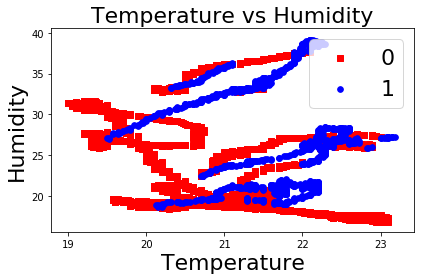

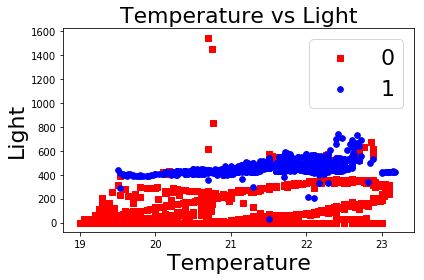

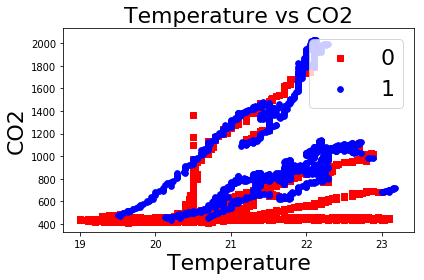

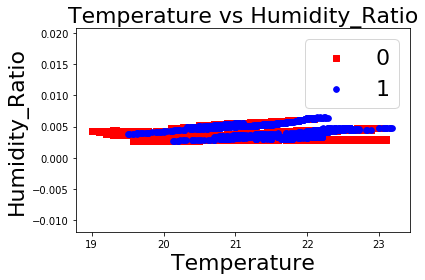

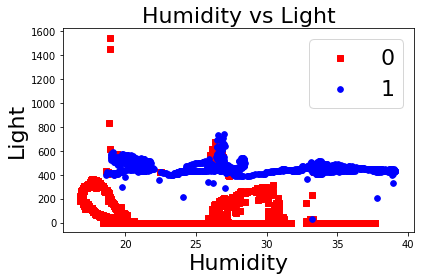

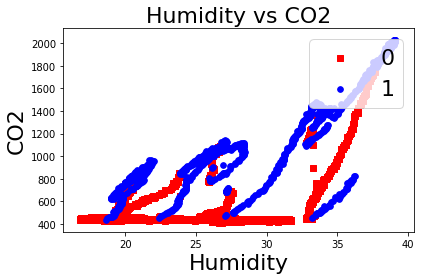

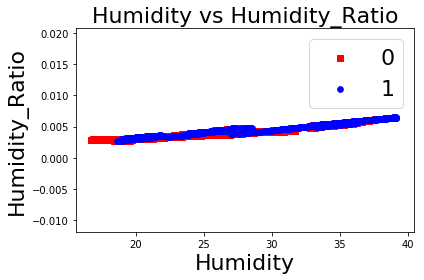

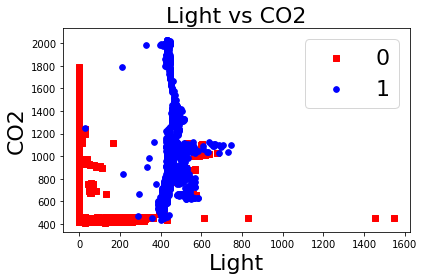

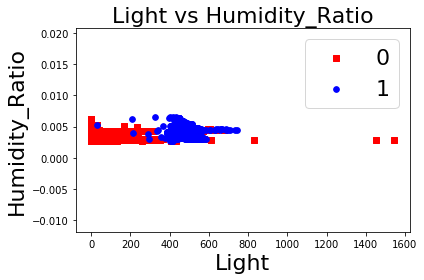

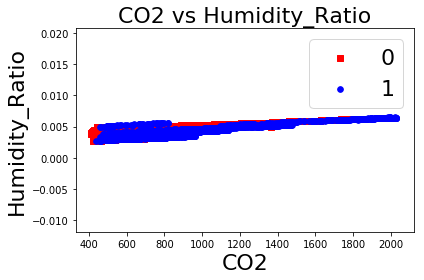

In [3]:
scatter_plot(x_training, y_training, feature_index_names)

### The sample correlation coeffient

Based on the scatter plots, it may be a good idea to choose **Light** and **CO2** as our discriminative features to predict the state of the office room. But, can we somehow quantify this? How about using _sample correlation coefficient_ between features and target varget values? Let $x_{i}^{(n)}$ denote $i$th feature of example $n$, and $y^{(n)}$ denote the corresponding target value. The _sample correlation coefficient_ between $x_{i}$ and $y$ is defined as follows
$$
r\left(x_{i}, y\right) = \frac{\sum\limits_{n=1}^{N} \left(x_{i}^{(n)} - \hat{x}_{i}\right) \left(y^{(n)} - \hat{y}\right)}{\sqrt{\sum\limits_{n=1}^{N} \left(x_{i}^{(n)} - \hat{x}_{i}\right)^{2} \sum\limits_{n=1}^{N} \left(y^{(n)} - \hat{y}\right)^{2}}},
$$
where $\hat{x}_{i} = \frac{1}{N}\sum\limits_{n=1}^{N}x_{i}^{(n)}$ is the sample mean of $x_{i}$, and analogously for $\hat{y}$. 

The following function `corr_coef` and code segment computes and displays the sample correlation coeffients between features and target values.

In [4]:
def corr_coef(x, y):
    x_m = (x - np.mean(x))
    y_m = (y - np.mean(y))
    r = np.sum(x_m * y_m) / np.sqrt(np.sum(x_m**2) * np.sum(y_m**2))
    return r

In [5]:
y = y_training.copy()
for i in np.arange(len(feature_index_names)):
    x_i = x_training[:, i]
    r = corr_coef(x_i, y)    
    print('r(' + feature_index_names[i] + ', Occupancy) = ' + '{:.4f}'.format(r))

r(Temperature, Occupancy) = 0.5382
r(Humidity, Occupancy) = 0.1330
r(Light, Occupancy) = 0.9074
r(CO2, Occupancy) = 0.7122
r(Humidity_Ratio, Occupancy) = 0.3003


As you can observe from the sample correlation coefficients between features and target values, **Light** and **CO2** are highly correlated to the state of the office room. Did you expect this? Based on the sample correlation, can you find out which features are highly correlated? Use the following code segment to compute the sample correlation coefficients between features.

In [6]:
for i in np.arange(len(feature_index_names)-1):
    for j in np.arange(i+1, len(feature_index_names)):
        x_i = x_training[:, i]
        x_j = x_training[:, j]
        r = corr_coef(x_i, x_j)
        print('r(' + feature_index_names[i] + ', ' + feature_index_names[j] + ') = ' + '{:.4f}'.format(r))

r(Temperature, Humidity) = -0.1418
r(Temperature, Light) = 0.6499
r(Temperature, CO2) = 0.5599
r(Temperature, Humidity_Ratio) = 0.1518
r(Humidity, Light) = 0.0378
r(Humidity, CO2) = 0.4390
r(Humidity, Humidity_Ratio) = 0.9552
r(Light, CO2) = 0.6640
r(Light, Humidity_Ratio) = 0.2304
r(CO2, Humidity_Ratio) = 0.6266


The column indexes of **Light** and **CO2** in `x_training` and `x_testing` arrays are 2 and 3, respectively. The following code segment creates a copy of training and testing datasets comprised of only features **Light** and **CO2**.

In [7]:
x_training_selected = x_training[:,[2, 3]]
x_testing_selected = x_testing[:,[2, 3]]
print(x_training_selected.shape)
print(x_testing_selected.shape)

(8143, 2)
(2665, 2)


## K-Nearest Neighbours

### Finding and plotting K-Nearest Neighbours of the query  point

Assume that we have a sample measurement (or query point, or test point) from the office room 
 $\mathbf{x}^{\left(q\right)} = \left[\begin{array}{c} x_{1}^{\left(q\right)} \\ x_{2}^{\left(q\right)}\end{array}\right] = \left[\begin{array}{l} \text{Light} \\ \text{CO}_{2}\end{array}\right] = \left[\begin{array}{l} 200.0000 \\ 1000.0000 \end{array}\right]$, and we want to predict if the room is occupied or unoccupied. If the number of features is less than or equal to 3, then we can either use 2D or 3D scatter plot to observe the proximity of the query point to the examples in our training dataset to make prediction about the room status. The following function and code segment do the scatter plot and shows K-Nearest Neighbours of the query point from the training dataset.

In [8]:
def scatter_plot_two_features_only(x, y, feature1_name, feature2_name, x_q, K=3, save_figures=False):
    c = ['r', 'b', 'g']
    m = ['s', 'o', '*']
    s = [32, 32, 64]
    l = [r'$0$', r'$1$', r'query']
    font_size = 22
    x_class0 = x[y==0.0, :]
    x_class1 = x[y==1.0, :]    
    figure_name = feature1_name + ' vs ' + feature2_name + ' Query'
    pl.figure(figure_name)
    pl.scatter(x_class0[:, 0], x_class0[:, 1], c=c[0], marker=m[0], s=s[0], label=l[0])
    pl.scatter(x_class1[:, 0], x_class1[:, 1], c=c[1], marker=m[1], s=s[1], label=l[1])
    pl.scatter(x_q[0], x_q[1], c=c[2], marker=m[2], s=s[2], label=l[2])
    # find the nearest neighbours
    d = np.sqrt(np.sum((x - x_q)**2, axis=1)) # use the Euclidean distance
    i = np.argsort(d)
    for k in np.arange(K):
        temp = np.vstack((x_q, x[i[k],:]))
        pl.plot(temp[:,0], temp[:,1], c = c[2], linewidth=2)    
    pl.xlabel(feature1_name, fontsize=font_size)
    pl.ylabel(feature2_name, fontsize=font_size)
    pl.legend(scatterpoints=1, fontsize=font_size, loc = 'upper right')
    pl.title(figure_name, fontsize=font_size)
    pl.tight_layout()
    if save_figures:
        pl.savefig(figure_name + '.png')

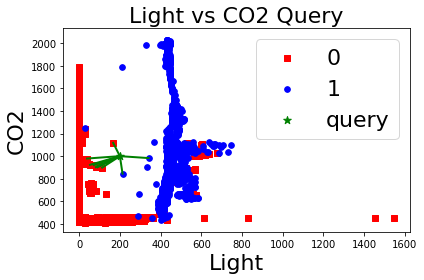

In [9]:
K = 11
x_q = np.array([200.0, 1000.0])
x_q.shape
scatter_plot_two_features_only(x_training_selected, y_training, feature_index_names[2], feature_index_names[3], x_q, K=K)

What is the prediction for the query point $\mathbf{x}^{\left(q\right)} = \left[\begin{array}{c} x_{1}^{\left(q\right)} \\ x_{2}^{\left(q\right)}\end{array}\right] = \left[\begin{array}{l} \text{Light} \\ \text{CO}_{2}\end{array}\right] = \left[\begin{array}{l} 200.0000 \\ 1000.0000 \end{array}\right]$ when $K=111$? In order to make prediction for $K=111$, you can use the following function and code segment.

In [10]:
def KNN(x, y, x_q, K=3):
    target_labels = np.unique(y) # unique set of target labels
    target_labels_counts = np.zeros(len(target_labels)) # keeps counts of target labels
    d = np.sqrt(np.sum((x - x_q)**2, axis=1)) # use the Euclidean distance
    i = np.argsort(d) # sort distance vector in ascending order
    for k in np.arange(len(target_labels)):
        target_labels_counts[k] = np.sum(y[i[0:K]]==target_labels[k]) # count the number of each target label in K Nearest Neighbourhood
    # apply the majority voting
    l = np.argmax(target_labels_counts)
    return target_labels[l]    

In [11]:
predicted_label = KNN(x_training_selected, y_training, x_q, K=111)
print('prediction = ' + '{:.0f}'.format(predicted_label))

prediction = 0


### Training error for different values of K


The following code segment computes training error for different values of $K$.

In [12]:
N = y_training.shape[0] # the number of examples in training dataset
print('{:>2} {:>16}'.format('K', 'Training Error'))
for K in np.arange(1, 34, 2):
    y_prediction = np.zeros(N)
    for n in np.arange(N):
        x_q = x_training_selected[n]
        y_prediction[n] = KNN(x_training_selected, y_training, x_q, K)
    classification_error = np.sum(y_training != y_prediction) / N
    print('{:>2.0f} {:>16.4f}'.format(K, classification_error))

 K   Training Error
 1           0.0000
 3           0.0069
 5           0.0086
 7           0.0095
 9           0.0099
11           0.0103
13           0.0103
15           0.0106
17           0.0107
19           0.0115
21           0.0115
23           0.0115
25           0.0115
27           0.0115
29           0.0115
31           0.0115
33           0.0117


Can you compute testing error of the classifier for $K = 111$?

## Logistic Regression

We can also use logistic regression to perform occupancy detection. In order to achieve this, first we need to define our hypothesis (or model):
$$
\begin{array}{rcl}
h_{\boldsymbol{\Theta}}(\mathbf{x}) & = & \frac{1}{1 + e^{-(\theta_{0} x_{0} + \theta_{1} x_{1} + \cdots + \theta_{d} x_{d})}} \\
& = & \frac{1}{1 + e^{-\mathbf{x} \boldsymbol{\Theta}^{T}}},
\end{array}
$$
where $\mathbf{x} = [x_{0}, x_{1}, \ldots, x_{d}]$, $\boldsymbol{\Theta}=[\theta_{0}, \theta_{1}, \ldots, \theta_{d}]$ and $x_{0} = 1$. 

The following function implements this model, which assumes that all vectors are row-major.

In [13]:
def h(x, theta):
    s = np.dot(x, theta.T)
    u = 1.0 / (1.0 + np.exp(-s))
    return u

Now, we need to define our loss function to learn the parameters of the model based on training dataset. We can use mean square error as our loss function, i.e.,

$$
J\left(\boldsymbol{\Theta}\right) = \frac{1}{2 N} \sum\limits_{n=1}^{N} \left(h_{ \boldsymbol{\Theta}}\left(\mathbf{x}^{\left(n\right)}\right) - y^{\left(n\right)} \right)^2 = \frac{1}{N} \sum\limits_{n=1}^{N}Cost\left(h_{ \boldsymbol{\Theta}}\left(\mathbf{x}^{\left(n\right)}\right) , y^{\left(n\right)}\right).
$$

The following function implements the loss function $J\left(\boldsymbol{\Theta}\right)$.

In [14]:
def J(x, y, theta):
    N = y.shape[0]
    mse = 1.0 / (2*N) * np.sum((h(x, theta) - y)**2)
    return mse    

Now, we need implement gradient descent solver to learn the parameters $\boldsymbol{\Theta}$ of our model. The following function implements batch gradient descent to learn the parameters $\boldsymbol{\Theta}$ on the training dataset.

In [15]:
def bgd(x, y, theta, alpha=0.1, epsilon=0.001, max_iter=1000):
    y = y[:, np.newaxis]
    N = y.shape[0]
    t = 0
    while True:
        # print the value of loss function for each iteration
        print('iteration #{:>8d}, loss = {:>8f}'.format(t, J(x,y,theta)))
        # keep a copy of the parameter vector before the update for checking the convergence criterion
        theta_previous = theta.copy()
        # update the parameter vector
        e = (h(x, theta) - y)
        theta  = theta - alpha * 1.0 / N * np.sum( e * x, axis=0)
        t = t + 1
        # check the convergence criterion
        if (np.max(np.abs(theta-theta_previous)) < epsilon) or (t>max_iter):
            break
    return theta

Normalize the data

In [16]:
m = np.mean(x_training, axis=0)
s = np.std(x_training, axis=0)
x_training = (x_training - m) / s
x_testing = (x_testing - m) / s

Augment training and testing vector to take advantage of fast matrix operations in NumPy.

In [17]:
x_training_aug = np.hstack((np.ones((x_training.shape[0],1)), x_training))
x_testing_aug = np.hstack((np.ones((x_testing.shape[0],1)), x_testing))

Create a random parameter vector and learn the parameters

In [18]:
theta = np.random.randn(1, x_training_aug.shape[1])
theta = bgd(x_training_aug, y_training, theta)

iteration #       0, loss = 0.125241
iteration #       1, loss = 0.120121
iteration #       2, loss = 0.115150
iteration #       3, loss = 0.110297
iteration #       4, loss = 0.105539
iteration #       5, loss = 0.100860
iteration #       6, loss = 0.096253
iteration #       7, loss = 0.091717
iteration #       8, loss = 0.087262
iteration #       9, loss = 0.082899
iteration #      10, loss = 0.078646
iteration #      11, loss = 0.074525
iteration #      12, loss = 0.070557
iteration #      13, loss = 0.066766
iteration #      14, loss = 0.063171
iteration #      15, loss = 0.059791
iteration #      16, loss = 0.056637
iteration #      17, loss = 0.053716
iteration #      18, loss = 0.051028
iteration #      19, loss = 0.048567
iteration #      20, loss = 0.046325
iteration #      21, loss = 0.044288
iteration #      22, loss = 0.042440
iteration #      23, loss = 0.040764
iteration #      24, loss = 0.039245
iteration #      25, loss = 0.037866
iteration #      26, loss = 0.036612
i

iteration #     223, loss = 0.011291
iteration #     224, loss = 0.011269
iteration #     225, loss = 0.011247
iteration #     226, loss = 0.011225
iteration #     227, loss = 0.011203
iteration #     228, loss = 0.011182
iteration #     229, loss = 0.011161
iteration #     230, loss = 0.011139
iteration #     231, loss = 0.011118
iteration #     232, loss = 0.011097
iteration #     233, loss = 0.011077
iteration #     234, loss = 0.011056
iteration #     235, loss = 0.011036
iteration #     236, loss = 0.011015
iteration #     237, loss = 0.010995
iteration #     238, loss = 0.010975
iteration #     239, loss = 0.010955
iteration #     240, loss = 0.010935
iteration #     241, loss = 0.010916
iteration #     242, loss = 0.010896
iteration #     243, loss = 0.010877
iteration #     244, loss = 0.010858
iteration #     245, loss = 0.010838
iteration #     246, loss = 0.010819
iteration #     247, loss = 0.010801
iteration #     248, loss = 0.010782
iteration #     249, loss = 0.010763
i

iteration #     471, loss = 0.008391
iteration #     472, loss = 0.008385
iteration #     473, loss = 0.008379
iteration #     474, loss = 0.008373
iteration #     475, loss = 0.008367
iteration #     476, loss = 0.008361
iteration #     477, loss = 0.008355
iteration #     478, loss = 0.008349
iteration #     479, loss = 0.008343
iteration #     480, loss = 0.008337
iteration #     481, loss = 0.008332
iteration #     482, loss = 0.008326
iteration #     483, loss = 0.008320
iteration #     484, loss = 0.008314
iteration #     485, loss = 0.008308
iteration #     486, loss = 0.008303
iteration #     487, loss = 0.008297
iteration #     488, loss = 0.008291
iteration #     489, loss = 0.008286
iteration #     490, loss = 0.008280
iteration #     491, loss = 0.008274
iteration #     492, loss = 0.008269
iteration #     493, loss = 0.008263
iteration #     494, loss = 0.008257
iteration #     495, loss = 0.008252
iteration #     496, loss = 0.008246
iteration #     497, loss = 0.008241
i

After the parameters are learned, we can test the performance of the classifier. Note that logistic regression returns a number in [0,1], thus we need to binarize it.

In [19]:
y_prediction = (h(x_testing_aug, theta)>=0.5)[:,0]
test_error = np.sum(y_testing != y_prediction) / y_testing.shape[0]
print('logistic regression test error = {:.4f}'.format(test_error))

logistic regression test error = 0.0214


Can you get a lower test error? What is training error?